In [232]:
!pip install torchmetrics --quiet

     |████████████████████████████████| 419 kB 5.0 MB/s 


In [8]:
# libary imports 
import os
import torch
from torch import nn
import torchvision
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm

import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import matplotlib.pyplot as plt
import numpy as np
import copy
import random
import time

import itertools
from functools import reduce
import operator
import torch.utils.data as data_utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 20]

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
from torch.utils.data import Subset


# Prepare CIFAR-10 dataset
trainset = CIFAR10(os.getcwd(), download=True, transform=transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

testset = CIFAR10(os.getcwd(), download=True, transform=transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))




#print(images, labels)

def my_fun(dataset):
    X=[]
    y=[]
    for feature, label in iter(dataset):
        X.append(feature)
        y.append(label)
    return X, y

X_train, y_train = my_fun(trainset)
X_test, y_test =my_fun(testset)


Files already downloaded and verified
Files already downloaded and verified


In [9]:

class MLPClassifer(nn.Module):
      '''
        Multilayer Perceptron.
      '''
      def __init__(self ):
        super().__init__()
        input=trainset.data[1].shape
        output=len(torch.unique(torch.tensor(trainset.targets)))
        hidden_layer_sizes=(64,32)
        self.layers = nn.Sequential(
          nn.Flatten(),
          nn.Linear(reduce(operator.mul, input),  hidden_layer_sizes[0]),
          nn.ReLU(),
          nn.Linear(hidden_layer_sizes[0],  hidden_layer_sizes[1]),
          nn.ReLU(),
          nn.Linear(hidden_layer_sizes[1], output)
        )

      def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

class Neural_Network(object):
    
    
    def __init__ (self,batch_size=2000,epochs=2,verbose=True,loss_function = nn.CrossEntropyLoss(),
         optimiser='adam',classifier= MLPClassifer(), 
         learning_rate=1e-3,  betas=(0.9,0.99) , eps=1e-8, weight_decay=0, amsgrad=False,
      momentum=0.9, nesterov=True, dampening=0, maximise=False):
      
      self.batch_size=batch_size
      self.epochs=epochs
      
      self.verbose=True
      #used inside the training/ testing loops
      self.running_loss = 0
      self.loss_function = loss_function
      self.classifier= classifier
      
      self.sm = torch.nn.Softmax()

      #some initial parameters for either standard optimisers
      self.learning_rate=learning_rate 
      self.betas= betas
      self.eps= eps
      self.weight_decay=weight_decay
      self.amsgrad=amsgrad 
      self.momentum=momentum
      self.nesterov=nesterov
      self.dampening=dampening
      self.maximise=maximise

      #default optimiser: adam 
      self.optimiser=self.set_optimiser_2(optimiser)
    
    #for some reason calling this function set_optimiser returns None 
    def set_optimiser_2(self, optimiser):
        #playing around with adam and sgd only at the moment
        #there is only two of them 
        if optimiser.lower().strip()=='adam':
            self.optimiser=torch.optim.Adam(self.classifier.parameters(),lr=self.learning_rate, betas=self.betas, eps=self.eps, weight_decay=self.weight_decay, amsgrad=self.amsgrad)
        elif optimiser.lower().strip()=='sgd':
            self.optimiser=torch.optim.SGD(self.classifier.parameters(),lr=self.learning_rate, weight_decay=self.weight_decay, momentum=0.9,nesterov=self.nesterov , dampening=self.dampening)
        return self.optimiser


    def get_optimiser(self):
      print(self.optimiser)

    
    def get_params(self): #get parameters
       if (self.optimiser != None) :
         return  (self.props(),self.optimiser.state_dict(), self.classifier.state_dict)
       else: return self.classifier.state_dict() 
  
    def fit(self,X,y):
        train = [*zip(X,y)]
        trainloader =  torch.utils.data.DataLoader(train,batch_size=8, shuffle=False, num_workers=2)
        for epoch in range(self.epochs):  # loop over the dataset 2 times
        
          running_loss =self.running_loss
          for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
             
            # zero the parameter gradients
            self.optimiser.zero_grad()

            # forward + compute loss+ backward + optimize
            outputs = self.classifier(inputs)
            loss = self.loss_function(outputs, labels)
            loss.backward()
            self.optimiser.step()
            # print statistics
            running_loss += loss.item()
            if i % self.batch_size == 1999:    # print every 2000 mini-batches
                if self.verbose==True:
                  print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / self.batch_size:.3f}')
                running_loss = 0.0

    def predict(self,X,y): #Predict using the multi-layer perceptron classifier.
      test = [*zip(X,y)]
      testloader = torch.utils.data.DataLoader(test,batch_size=8, shuffle=False, num_workers=2)
      prediction_list=[]
      # again no gradients needed
      with torch.no_grad():
          for data in testloader:
              images, labels = data
              outputs = self.classifier(images)
              estimation, predictions = torch.max(outputs, 1)
              prediction_list.append(predictions)
      return prediction_list #torch.stack(prediction_list)


    def predict_log_proba(self,X,y):  #	Return the log of probability estimates.
        data = [*zip(X,y)]
        loader =  torch.utils.data.DataLoader(data,batch_size=8, shuffle=False, num_workers=2)
        y_prob=self.predict_proba(loader)
        log_proba=np.log(y_prob)
        return log_proba
 

    def predict_proba(self,X,y):	#Probability estimates.
      probabilities_list=[]
      data = [*zip(X,y)]
      loader =  torch.utils.data.DataLoader(data,batch_size=8, shuffle=False, num_workers=2)
      # again no gradients needed
      with torch.no_grad():
          for data in loader:
              images, labels = data
              outputs = self.classifier(images)
              probabilities_list.append(self.sm(outputs) )
              estimation, predictions = torch.max(outputs, 1)
      return probabilities_list
      

    def score(self,X,y): #Return the mean accuracy on the given test data and labels.
        prediction_list=[]
        targets_list=[]
        data = [*zip(X,y)]
        loader =  torch.utils.data.DataLoader(data,batch_size=8, shuffle=False, num_workers=2)
        num_classes=len(torch.unique(torch.tensor(y)))
        #set it to true if you have a list of available labels in text format
        labels_available=False
        if labels_available:
            classes = ('plane', 'car', 'bird', 'cat',
                    'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
            # prepare to count predictions for each class
            correct_pred = {classname: 0 for classname in classes}
            total_pred = {classname: 0 for classname in classes}
        #use the class number as key
        else: 
            classes=tuple(np.arange(num_classes))  
            correct_pred = {classname: 0 for classname in np.arange(num_classes)}
            total_pred= {classname: 0 for classname in np.arange(num_classes)}

        # again no gradients needed
        with torch.no_grad():
            for data in loader:
                images, labels = data
                targets_list.append(labels)
                outputs = self.classifier(images)
                estimation, predictions = torch.max(outputs, 1)
                prediction_list.append(predictions)
                # collect the correct predictions for each class
                for label, prediction in zip(labels, predictions):
                    if label == prediction:
                        correct_pred[classes[label]] += 1
                    total_pred[classes[label]] += 1
        accuracies={}
        # print accuracy for each class
        for classname, correct_count in correct_pred.items():
            accuracy = 100 * float(correct_count) / total_pred[classname]
            accuracies[classname]=accuracy
            if self.verbose:
              print(f'Accuracy for class: {classname} is {accuracy:.1f} %')
        return targets_list,prediction_list
        

    def set_params(self, attr, value): #sets parameters
        setattr(self, attr, value)
        
    def props(cls):   
        return [i for i in cls.__dict__.items() if i[:1] != '_']

    def get_classifier(self):
        return self.classifier()

    def set_optimiser(self, optimiser_choice):
        return 

    def get_classification_report(self,y, y_pred):
        y_prime = np.stack([np.stack([d for d in d_]) for d_ in y]).flatten()
        y_pred_prime=np.stack([np.stack([d for d in d_]) for d_ in y_pred]).flatten()   
        print(classification_report(y_prime, y_pred_prime))


    def plot_confusion_matrix(self,cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()


    def get_confusion_matrix(self,y, y_pred, plot=True):
          y_prime = np.stack([np.stack([d for d in d_]) for d_ in y]).flatten()
          y_pred_prime=np.stack([np.stack([d for d in d_]) for d_ in y_pred]).flatten()
          cnf_matrix = confusion_matrix(y_prime, y_pred_prime,labels=np.arange(10))
          np.set_printoptions(precision=2)
          # Plot non-normalized confusion matrix
          if plot==True:
            plt.figure()
            self.plot_confusion_matrix(cnf_matrix, classes=['plane', 'car', 'bird', 'cat',
                                'deer', 'dog', 'frog', 'horse', 'ship', 'truck'],
                                  title='Confusion matrix, without normalization')
              


In [15]:
model= Neural_Network()
model.set_optimiser_2('adam')
model.fit(X_train,y_train)


[1,  2000] loss: 1.481
[1,  4000] loss: 1.439
[1,  6000] loss: 1.456
[2,  2000] loss: 1.424
[2,  4000] loss: 1.388
[2,  6000] loss: 1.404


In [11]:
y, y_pred=model.score(X_test, y_test)

Accuracy for class: 0 is 39.4 %
Accuracy for class: 1 is 62.8 %
Accuracy for class: 2 is 28.1 %
Accuracy for class: 3 is 47.7 %
Accuracy for class: 4 is 33.9 %
Accuracy for class: 5 is 27.9 %
Accuracy for class: 6 is 60.7 %
Accuracy for class: 7 is 61.8 %
Accuracy for class: 8 is 68.9 %
Accuracy for class: 9 is 62.6 %


In [271]:
#  full tensor form
y_prime=torch.stack(y)
y_pred_prime=torch.stack(y_pred)

# full numpy form
y_prime= y_prime.numpy()
y_pred_numpy= y_pred_prime.numpy()

In [12]:
model.get_classification_report(y, y_pred)

              precision    recall  f1-score   support

           0       0.68      0.39      0.50      5000
           1       0.61      0.63      0.62      5000
           2       0.42      0.28      0.34      5000
           3       0.31      0.48      0.37      5000
           4       0.48      0.34      0.40      5000
           5       0.44      0.28      0.34      5000
           6       0.48      0.61      0.54      5000
           7       0.53      0.62      0.57      5000
           8       0.58      0.69      0.63      5000
           9       0.51      0.63      0.57      5000

    accuracy                           0.49     50000
   macro avg       0.50      0.49      0.49     50000
weighted avg       0.50      0.49      0.49     50000



Confusion matrix, without normalization
[[1972  359  272  247  134  103  108  305 1067  433]
 [  94 3138   55  165   52   28  100   93  283  992]
 [ 230   88 1404  921  554  271  721  481  189  141]
 [  66   92  249 2386  161  630  672  300  202  242]
 [ 140   86  581  596 1696  179  827  595  185  115]
 [  45   71  263 1853  193 1393  480  416  143  143]
 [  21   66  220  766  357  201 3035  153   52  129]
 [  66  108  194  489  306  228  172 3088   89  260]
 [ 198  355   74  164   85   60   55   72 3444  493]
 [  83  779   50  223   32   58  131  271  243 3130]]


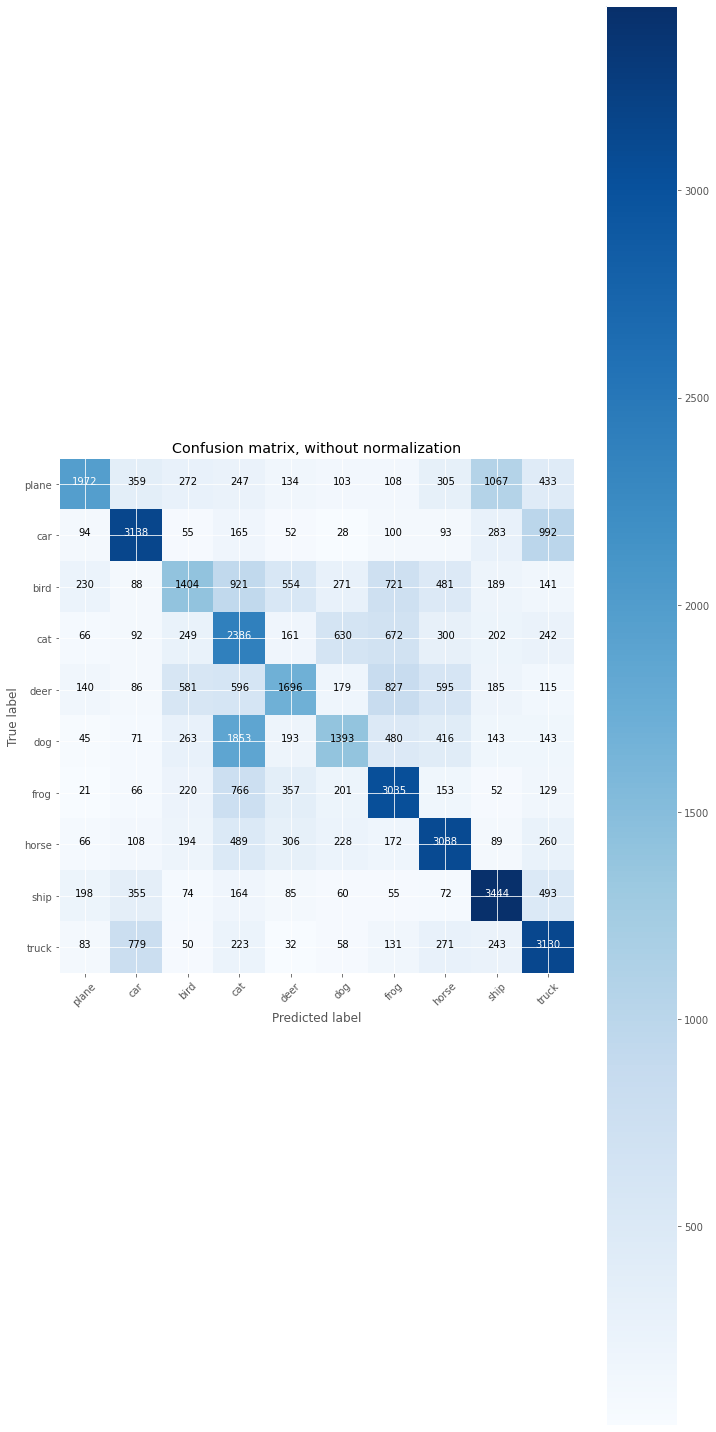

In [14]:
model.get_confusion_matrix(y, y_pred)

In [301]:
from sklearn.metrics import multilabel_confusion_matrix
y_prime = np.stack([np.stack([d for d in d_]) for d_ in y]).flatten()
y_pred_prime=np.stack([np.stack([d for d in d_]) for d_ in y_pred]).flatten()
multilabel_confusion_matrix(y_prime, y_pred_prime)

6
50000


array([[[43997,  1003],
        [ 2985,  2015]],

       [[43397,  1603],
        [ 2183,  2817]],

       [[43377,  1623],
        [ 3802,  1198]],

       [[38833,  6167],
        [ 2339,  2661]],

       [[42319,  2681],
        [ 2935,  2065]],

       [[44019,   981],
        [ 3918,  1082]],

       [[42074,  2926],
        [ 2156,  2844]],

       [[41563,  3437],
        [ 1705,  3295]],

       [[42068,  2932],
        [ 1297,  3703]],

       [[42829,  2171],
        [ 2204,  2796]]])

Confusion matrix, without normalization
[[2015  263  299  316  179   43   93  334 1155  303]
 [  80 2817   83  254   66   21  137  147  399  996]
 [ 257   88 1198  967  844  169  599  592  204   82]
 [  71   75  188 2661  259  356  605  415  234  136]
 [ 182   64  391  539 2065  103  670  702  203   81]
 [  38   55  248 2075  239 1082  456  577  150   80]
 [  20   57  193  896  583   96 2844  202   53   56]
 [  65   98  121  531  351  127  169 3295  100  143]
 [ 191  254   48  222  118   24   50   96 3703  294]
 [  99  649   52  367   42   42  147  372  434 2796]]


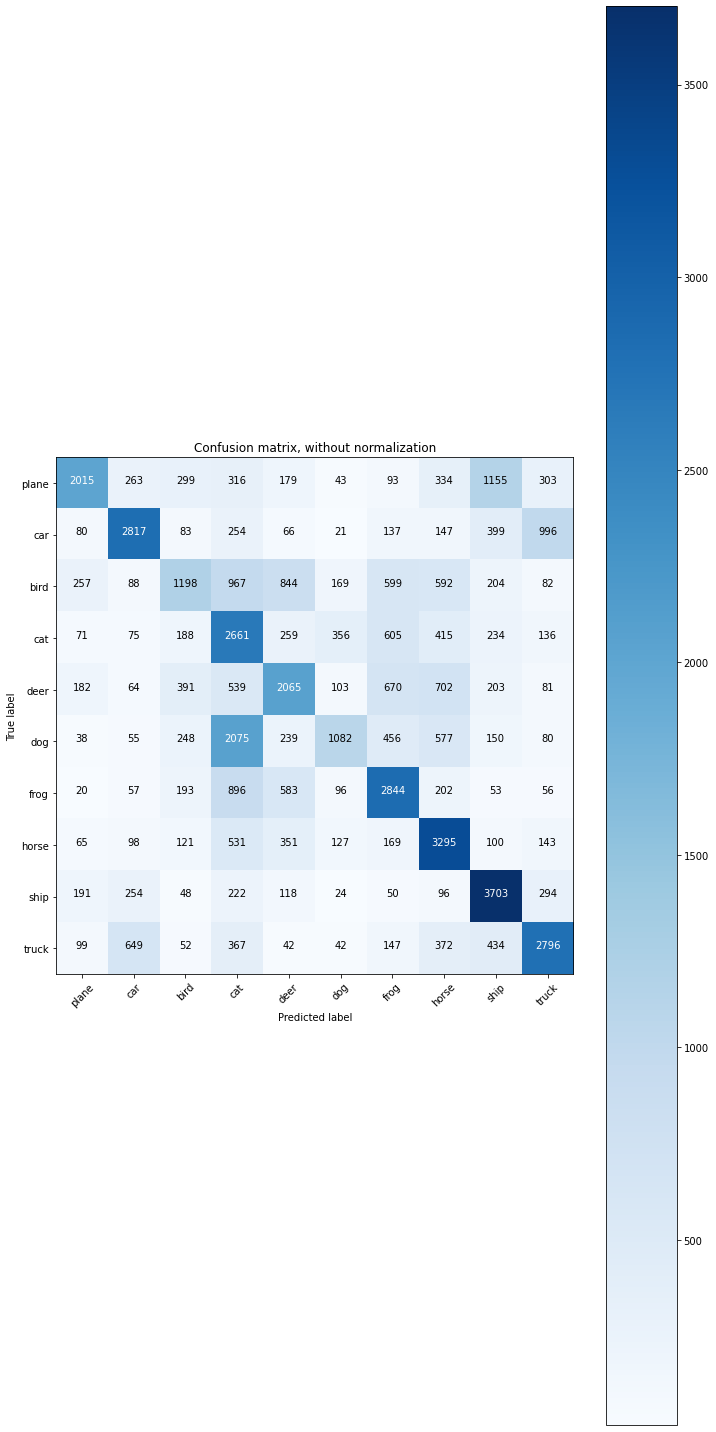

In [185]:
#roc curves are practically useless- not working with MLP classifier 
# calculate the false positive and the true positive rate from the confusion matrix 
#precision recall display 

def  precision_recall:
   ''' try to find the equivalent of one_vs_all_classifiers'''
   #Returning the parameterrs list as a sum of integers 
   # 

8.0

In [149]:
print(classification_report(y_prime, y_pred_prime))

              precision    recall  f1-score   support

           0       0.62      0.46      0.53      5000
           1       0.59      0.65      0.61      5000
           2       0.44      0.23      0.30      5000
           3       0.32      0.42      0.36      5000
           4       0.47      0.33      0.39      5000
           5       0.44      0.31      0.36      5000
           6       0.45      0.63      0.52      5000
           7       0.52      0.63      0.57      5000
           8       0.57      0.71      0.63      5000
           9       0.54      0.56      0.55      5000

    accuracy                           0.49     50000
   macro avg       0.49      0.49      0.48     50000
weighted avg       0.49      0.49      0.48     50000



In [152]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

y_score = model.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=clf.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

TypeError: ignored

In [1]:
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
plt.style.use('ggplot')



classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=0))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

NameError: ignored